# Neural Network for Thermodynamic Property Prediction (After Feature Engineering)

This notebook implements an **enhanced neural network model** that incorporates advanced feature engineering using **RDKit molecular descriptors** to predict thermodynamic properties. This approach builds upon the baseline model to demonstrate the impact of domain-specific features.

## Key Enhancements Over Baseline

### **Advanced Feature Engineering with RDKit**
- **3D Molecular Inertia**: Principal moments of inertia (I1, I2, I3) and derived features
- **Topological Polar Surface Area (TPSA)**: Molecular polarity descriptor
- **Molar Refractivity (MR)**: Molecular volume and polarizability indicator
- **Gasteiger Partial Charges**: Mean and standard deviation of atomic charges

## Workflow Overview

### 1. **Enhanced Data Preparation**
- Loads molecular dataset with SMILES representations
- **Computes RDKit descriptors** using 3D molecular conformations
- Applies **log transformation** to specific targets (`mu`, `r2`)
- Uses **stratified splitting** based on molecular size for representative train/test sets

### 2. **Feature Engineering Pipeline**
- **3D Conformation Generation**: UFF optimization for realistic molecular geometries
- **Descriptor Computation**: 
  - `inertia_sum`: I1 + I2 + I3 (molecular size)
  - `inertia_ratio`: I1/I2 (molecular shape asymmetry)
  - `TPSA`: Topological polar surface area
  - `MR`: Molar refractivity
  - `chg_mean`, `chg_std`: Gasteiger charge statistics

### 3. **Model Architecture & Training**
- **Two-stage hyperparameter optimization** with expanded feature space
- **Sequential network** with 1-2 hidden layers, batch normalization, and dropout
- **Separate scaling** for enhanced features and target variables

### 4. **Performance Comparison**
- Same evaluation metrics as baseline (RMSE, MAE, R²)
- Direct comparison with baseline model performance
- Analysis of feature engineering impact on prediction accuracy

## Expected Improvements

The enhanced molecular descriptors should improve model performance by:
- **Better capturing 3D molecular structure** through inertia descriptors
- **Encoding electronic properties** via TPSA and Gasteiger charges
- **Representing molecular interactions** through molar refractivity
- **Providing complementary information** to functional group counts

This approach demonstrates how **domain knowledge integration** can enhance machine learning models for molecular property

In [1]:
# Install RDKit and Keras Tuner
!pip install rdkit
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors

In [3]:
# Helper functions
def compute_descriptors(smiles_series):
    """Compute 3D inertia, TPSA, MR, and Gasteiger charge stats."""
    cols = ('inertia_sum','inertia_ratio','TPSA','MR','chg_mean','chg_std')
    records = []
    for smi in smiles_series:
        m = Chem.AddHs(Chem.MolFromSmiles(smi))
        if AllChem.EmbedMolecule(m, randomSeed=42) != 0:
            vals = [np.nan]*6
        else:
            AllChem.UFFOptimizeMolecule(m, confId=0)
            I1, I2, I3 = rdMolDescriptors.CalcPMI1(m), rdMolDescriptors.CalcPMI2(m), rdMolDescriptors.CalcPMI3(m)
            vals = [I1+I2+I3, I1/(I2+1e-6), rdMolDescriptors.CalcTPSA(m), Descriptors.MolMR(m)]
            AllChem.ComputeGasteigerCharges(m)
            ch = [float(a.GetProp('_GasteigerCharge')) for a in m.GetAtoms()]
            vals += [np.mean(ch), np.std(ch)]
        records.append(dict(zip(cols, vals)))
    return pd.DataFrame.from_records(records)

# Function to Evaluate all targets using RMSE, MAE, and R²
def evaluate_all(y_true, y_pred, target_names):
    """Compute RMSE, MAE and R² per target column."""
    records = []
    for i, name in enumerate(target_names):
        yt, yp = y_true[:, i], y_pred[:, i]
        records.append({
            "Target": name,
            "RMSE": np.sqrt(mean_squared_error(yt, yp)),
            "MAE": mean_absolute_error(yt, yp),
            "R2": r2_score(yt, yp)
        })
    return pd.DataFrame(records).set_index("Target")

In [4]:
# Load dataset
df = pd.read_csv('dataset_9May.csv')
smiles = df.pop('Molecule') # Drop SMILES column
desc_df = compute_descriptors(smiles)   # Compute descriptors from RDkit
df = pd.concat([df, desc_df], axis=1)   # Merge descriptors with main DataFrame

# Define targets and features
targets = ['gap','mu','alpha','homo','lumo','r2','zpve','U0','U','H','G','Cv']
features = [c for c in df.columns if c not in targets + ['Molecule']]
X = df[features].fillna(0)
Y = df[targets].copy()

# Proper log transformation with safety checks
log_targets = ['mu', 'r2']
for col in log_targets:
    # Add small constant to handle zeros/negatives, then apply log1p
    Y[col] = np.log1p(np.maximum(Y[col], 1e-8))

# Train/test split stratified by molecule size
# Step 1: Identify atomic columns (single uppercase letters)
atoms = [c for c in df.columns if len(c)==1 and c.isupper()]
# Step 2: Calculate total atom count for each molecule
# Sum of all atomic counts = total molecular size
size = df[atoms].sum(axis=1)
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2, random_state=42,
                                         stratify=pd.qcut(size, 5))
# Step 3: Create 5 size-based strata using quantiles (stratify=pd.qcut(size, 5))
# Divides molecules into 5 equal-sized groups based on total atom count

# Create validation split from training data
X_train, X_val, Y_train, Y_val = train_test_split(X_tr, Y_tr, test_size=0.2, random_state=42)

# Separate scaling for inputs and outputs
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Scale the new train/val/test splits
X_train_scaled = scaler_X.fit_transform(X_train)  # Fit on training data only
X_val_scaled = scaler_X.transform(X_val)          # Transform validation data
X_test_scaled = scaler_X.transform(X_te)          # Transform test data

Y_train_scaled = scaler_Y.fit_transform(Y_train)  # Fit on training data only
Y_val_scaled = scaler_Y.transform(Y_val)          # Transform validation data
Y_test_scaled = scaler_Y.transform(Y_te)          # Transform test data

In [5]:
# Define the model building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()   # Initialize a Sequential model
    model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))  # Input layer with the number of features

    # First layer
    model.add(tf.keras.layers.Dense(
        hp.Int('units_1', 64, 512, step=64),
        activation='relu'
    ))
    model.add(tf.keras.layers.BatchNormalization()) # Batch normalization for better training stability
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))   # Dropout for regularization

    # Optional second layer
    if hp.Boolean('second_layer'):
        model.add(tf.keras.layers.Dense(
            hp.Int('units_2', 32, 256, step=32),
            activation='relu'
        ))
        model.add(tf.keras.layers.BatchNormalization()) # Batch normalization for better training stability
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))   # Dropout for regularization

    # Output layer
    model.add(tf.keras.layers.Dense(Y_train_scaled.shape[1]))

    # Learning rate and optimizer tuning
    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])    # Choice between Adam and RMSprop optimizers
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')   # Logarithmic sampling for learning rate

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)   # Adam optimizer with tuned learning rate
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)    # RMSprop optimizer with tuned learning rate

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])     # Compile model with MSE loss and MAE metric
    return model

In [6]:
# HYBRID APPROACH 1: Two-Stage Tuning
print("🔍 Stage 1: Quick broad search...")

# Stage 1: Quick broad search using RandomSearch for a wide exploration of hyperparameters
tuner_broad = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,        # Medium number of trials
    executions_per_trial=1, # Single execution for faster results
    directory='nn_tuning_broad',    # Directory to save tuner results
    project_name='molecular_broad',
    overwrite=True
)

# Perform the broad search to find promising candidates
tuner_broad.search(
    X_train_scaled, Y_train_scaled,
    epochs=30,            # Quick epochs
    validation_data=(X_val_scaled, Y_val_scaled),   # Validation set for early stopping
    batch_size=64,      # Batch size for training
    callbacks=[
        tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights=True)
    ],  # Early stopping to prevent overfitting
    verbose=0   # Suppress output for cleaner logs
)

# Get top 3 hyperparameter sets
top_hps = tuner_broad.get_best_hyperparameters(3)
print(f"✅ Stage 1 complete! Found {len(top_hps)} promising candidates")

# Stage 2: Fine-tune the best candidates
print("🔍 Stage 2: Fine-tuning best candidates...")

# Function to build model with refined hyperparameters around best candidates
def build_model_refined(hp, base_hps):

    model = tf.keras.Sequential()   # Initialize a Sequential model
    model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))  # Input layer with the number of features

    # First layer: units_1
    base_units = base_hps.get('units_1')
    # Ensure base_units is defined, default to 128 if not found
    units_1 = hp.Int('units_1',
                     max(64, base_units - 64),
                     min(512, base_units + 64),
                     step=32)
    model.add(tf.keras.layers.Dense(units_1, activation='relu'))    # First dense layer with ReLU activation
    model.add(tf.keras.layers.BatchNormalization())                 # Batch normalization for better training stability

    # Dropout 1
    base_dropout_1 = base_hps.get('dropout_1') if 'dropout_1' in base_hps.values else 0.2  # Use base hyperparameter if available, otherwise default to 0.2
    # Add dropout layer for regularization
    model.add(tf.keras.layers.Dropout(
        hp.Float('dropout_1',
                 max(0.1, base_dropout_1 - 0.1),
                 min(0.5, base_dropout_1 + 0.1),
                 step=0.05)))

    # Optional second layer
    if hp.Boolean('second_layer'):
        base_units_2 = base_hps.get('units_2') if 'units_2' in base_hps.values else 128     # Use base hyperparameter if available, otherwise default to 128
        units_2 = hp.Int('units_2',
                         max(32, base_units_2 - 32),
                         min(256, base_units_2 + 32),
                         step=16)
        model.add(tf.keras.layers.Dense(units_2, activation='relu'))        # Second dense layer with ReLU activation
        model.add(tf.keras.layers.BatchNormalization())                     # Batch normalization for better training stability

        base_dropout_2 = base_hps.get('dropout_2') if 'dropout_2' in base_hps.values else 0.2   # Use base hyperparameter if available, otherwise default to 0.2
        # Add dropout layer for regularization
        model.add(tf.keras.layers.Dropout(
            hp.Float('dropout_2',
                     max(0.1, base_dropout_2 - 0.1),
                     min(0.5, base_dropout_2 + 0.1),
                     step=0.05)))

    # Output layer
    model.add(tf.keras.layers.Dense(Y_train_scaled.shape[1]))

    # Learning rate
    base_lr = base_hps.get('learning_rate') if 'learning_rate' in base_hps.values else 1e-3     # Use base hyperparameter if available, otherwise default to 1e-3
    learning_rate = hp.Float('learning_rate',
                             base_lr * 0.5,
                             base_lr * 2.0,
                             sampling='log')    # Logarithmic sampling for learning rate

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)   # Adam optimizer with tuned learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])     # Compile model with MSE loss and MAE metric
    return model

# Fine-tune around the best hyperparameters
best_base_hps = top_hps[0]      # Get the best hyperparameters from the first candidate
# Fine-tune using RandomSearch with refined hyperparameters
tuner_refined = kt.RandomSearch(
    lambda hp: build_model_refined(hp, best_base_hps),
    objective='val_loss',
    max_trials=10,        # Fewer trials, focused search
    executions_per_trial=2,  # More stable results
    directory='nn_tuning_refined',
    project_name='molecular_refined',
    overwrite=True
)

# Perform the refined search to find the best hyperparameters
tuner_refined.search(
    X_train_scaled, Y_train_scaled,
    epochs=100,           # Full epochs for final candidates
    validation_data=(X_val_scaled, Y_val_scaled),
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ],
    verbose=0
)

# Get the final best hyperparameters
final_best_hps = tuner_refined.get_best_hyperparameters(1)[0]
print("✅ Stage 2 complete! Best hyperparameters found:")

# Build final model with best hyperparameters
final_model = build_model_refined(kt.HyperParameters(), best_base_hps)

# Copy the best hyperparameters to the final model
for key, value in final_best_hps.values.items():
    setattr(final_model, key, value)

# Rebuild the final model properly
final_model = build_model(final_best_hps)

print("Final best hyperparameters:")
for k, v in final_best_hps.values.items():
    print(f"  {k}: {v}")

🔍 Stage 1: Quick broad search...
✅ Stage 1 complete! Found 3 promising candidates
🔍 Stage 2: Fine-tuning best candidates...
✅ Stage 2 complete! Best hyperparameters found:
Final best hyperparameters:
  units_1: 352
  dropout_1: 0.1
  second_layer: True
  learning_rate: 0.002982494158687706
  units_2: 160
  dropout_2: 0.20000000000000004
  optimizer: adam


In [7]:
# Final training on full training data
best_batch_size = final_best_hps.get('batch_size') if 'batch_size' in final_best_hps.values else 64     # Use base hyperparameter if available, otherwise default to 64
# Final training on full training data
history = final_model.fit(
    X_train_scaled, Y_train_scaled,
    epochs=200,
    batch_size=64,
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=[
        tf.keras.callbacks.EarlyStopping('val_loss', patience=15, restore_best_weights=True),   # Early stopping to prevent overfitting
        tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=7, min_lr=1e-6)   # Reduce learning rate on plateau
    ],
    verbose=1
)

# Proper evaluation with inverse transformations
y_pred_scaled = final_model.predict(X_test_scaled)

# Inverse transform predictions and true values
Y_pred_original = scaler_Y.inverse_transform(y_pred_scaled)
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled)

# Convert to DataFrame
Y_pred_df = pd.DataFrame(Y_pred_original, columns=targets)
Y_test_df = pd.DataFrame(Y_test_original, columns=targets, index=Y_te.index)

# Inverse log transformation for specific targets
for col in log_targets:
    Y_pred_df[col] = np.expm1(Y_pred_df[col])
    Y_test_df[col] = np.expm1(Y_test_df[col])



Epoch 1/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0673 - mae: 0.7408 - val_loss: 0.4040 - val_mae: 0.4908 - learning_rate: 0.0030
Epoch 2/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3219 - mae: 0.4206 - val_loss: 0.2898 - val_mae: 0.4059 - learning_rate: 0.0030
Epoch 3/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2317 - mae: 0.3489 - val_loss: 0.2080 - val_mae: 0.3314 - learning_rate: 0.0030
Epoch 4/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1986 - mae: 0.3189 - val_loss: 0.1710 - val_mae: 0.2862 - learning_rate: 0.0030
Epoch 5/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1773 - mae: 0.2973 - val_loss: 0.1556 - val_mae: 0.2639 - learning_rate: 0.0030
Epoch 6/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1752 - mae: 0.2968 - val_loss: 0.1520 - val_mae: 0.2539 - learning_rate: 0.0030
Epoch 7/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1679 - mae: 0.2880 - val_loss: 0.1351 - val_mae: 0.2422 - learning_rate: 0.003

In [8]:
# Evaluation of model performance per target
results = evaluate_all(Y_test_df.values, Y_pred_df.values, targets)
print("\nPer-target performance:")
print(results)

# Overall evaluation metrics
overall_r2 = r2_score(Y_test_df.values, Y_pred_df.values)
overall_rmse = np.sqrt(mean_squared_error(Y_test_df.values, Y_pred_df.values))
print(f"\nOverall R²: {overall_r2:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")


Per-target performance:
             RMSE        MAE        R2
Target                                
gap      0.018535   0.013114  0.840577
mu       1.002332   0.671809  0.577322
alpha    1.337576   0.816917  0.961119
homo     0.010210   0.007180  0.812111
lumo     0.016383   0.011565  0.869440
r2      75.340534  45.315064  0.904678
zpve     0.005565   0.003875  0.968621
U0       1.465076   1.023708  0.997617
U        1.465088   1.023696  0.997617
H        1.465087   1.023696  0.997617
G        1.465030   1.023699  0.997617
Cv       0.910063   0.700482  0.929566

Overall R²: 0.9045
Overall RMSE: 21.7723


### **Visualization**

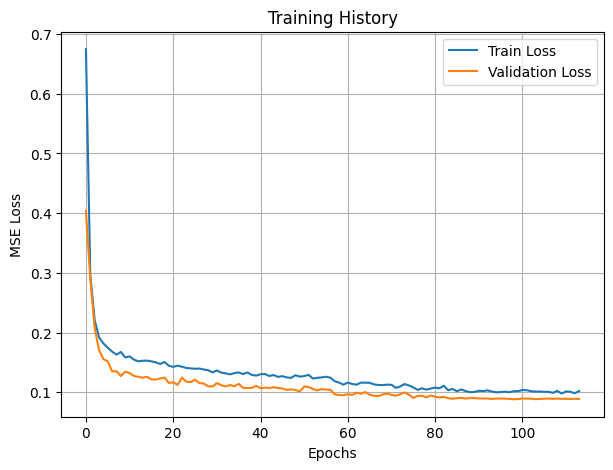

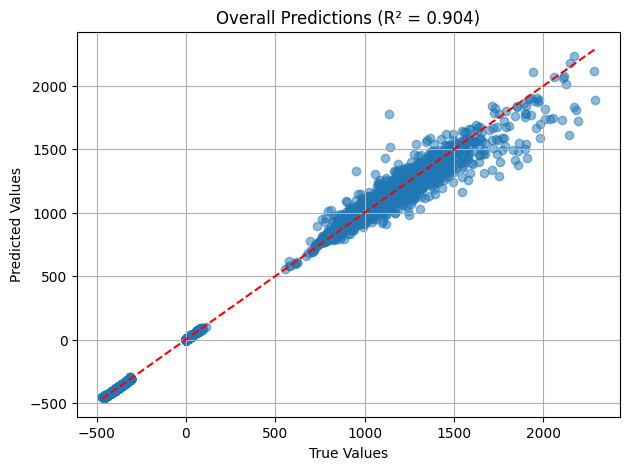

In [9]:
# Training history versus epochs
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

# Prediction scatter plot - overall
plt.figure(figsize=(7, 5))
plt.scatter(Y_test_df.values.flatten(), Y_pred_df.values.flatten(), alpha=0.5)
plt.plot([Y_test_df.values.min(), Y_test_df.values.max()],
         [Y_test_df.values.min(), Y_test_df.values.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Overall Predictions (R² = {overall_r2:.3f})')
plt.grid(True)
plt.show()


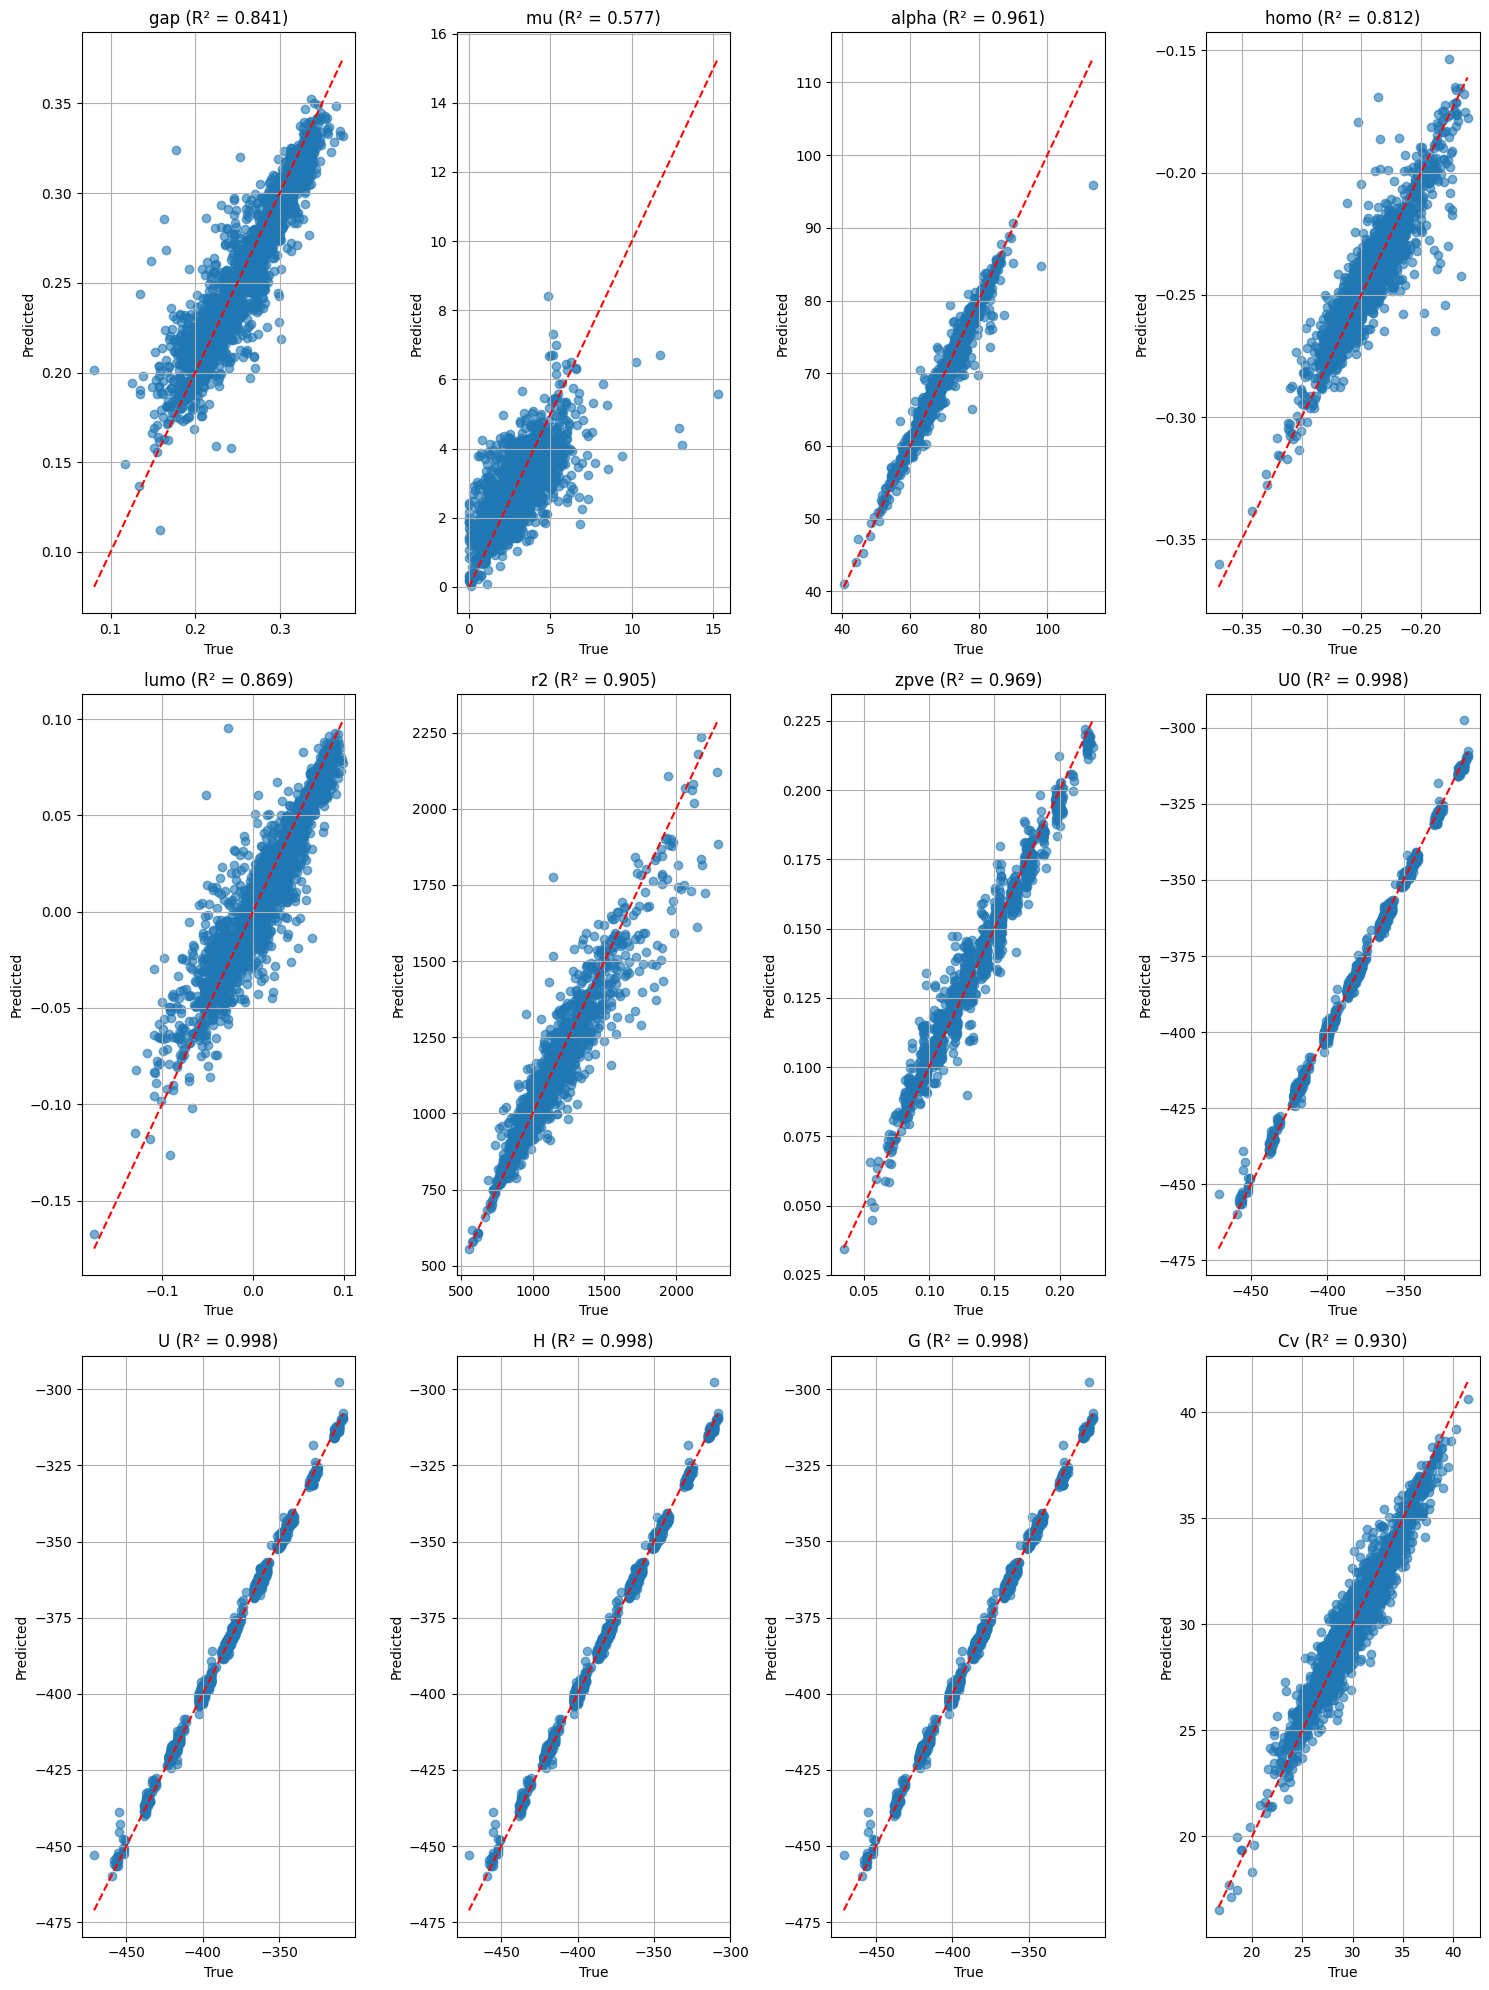

In [10]:
# Individual parity plots per target
fig, axes = plt.subplots(3, 4, figsize=(15, 20))
axes = axes.flatten()

for i, target in enumerate(targets):
    ax = axes[i]
    ax.scatter(Y_test_df[target], Y_pred_df[target], alpha=0.6)
    ax.plot([Y_test_df[target].min(), Y_test_df[target].max()],
            [Y_test_df[target].min(), Y_test_df[target].max()], 'r--')
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{target} (R² = {results.loc[target, "R2"]:.3f})')
    ax.grid(True)

plt.tight_layout()
plt.show()